# Lab 6: Generative Adversarial Networks (GANs)

In this lab, we will develop several basic GANs and experiment with them.

**Reference: Coursera, Build Basic Generative Adversarial Networks (GANs)**

## Generative Models vs Discriminative Models

Discriminative model is one typically used for classification in machine learning.
They learn how to distinguish between classes such as cars and dogs, and are often called classifiers.
Discriminative models take a set of features $X$, such as having a nose or wheels and from these features determine a category why of whether the image is.
Meaning that they try to model the probability of class $Y$ given a set of features $X$.

Assuming $X$ is features, and $Y$ is classes, the discriminative models equation can be

$$P(Y|X) = D(X)$$

On the other hand, generative models try to learn how to make a realistic representation of some class.
They take some random input represented by the noise here, which could take on the value.
The point is, the noise represents a random set of values going into the generative model.
The generative model also sometimes takes in a class $Y$ such as a dog.
From these inputs, it's goal is to generate a set of features $X$ that look like a realistic dog.
You might wonder why we need this noise in the first place.
The noise is larger to ensure that what's generated isn't actually the same dog each time.
This is because generating just one dog is no fun and also a little pointless.
Thus, some random noise $\xi$ that also goes in as an input, and
Generative models try to capture the probability distribution of $X$, the different features which is not completed sometime, but not all the time given that class $Y$.

By assuming $\xi$ as random noise, the generative models's equation is:
$$P_{\xi\sim N(\cdots)}(X = G(\xi,Y))=P_{data}(X)$$

## Generative Adversarial Networks (GANS)

GANs are composed of two models, a generator which generates images, and a discriminator that's actually a discriminative model hidden inside of this.
The generator takes in some random noise input into this generator.
There is an optional class, but we will talk about this later.
As an output, it can generate that same dog over time.
However, in the beginning they can also be evil, because the generator does not know what it needs to generate, so they want someone guiding them.
Thata's why a discriminator will take this job.
The discriminator looking at fake and real images and simultaneously trying to figure out which ones are real and which ones are fake.
Over time, each model tries to one up each other.
These models compete against each other which is why they're called **adversarial**, in the name **generative adversarial networks**.
Finally, The discriminator, and the generator can take in any random noise and produce a realistic image.

In summary, generative models learn to produce realistic examples, like an artist that can paint paintings that look like photos. Meanwhile, discriminative models distinguish between different classes.

Here is the basic GAN model described by Goodfellow et al. (2014):

<img src="img/gan_architecture-1.png" title="GAN Framework" style="width: 640px;" />

After this lab, you may be interested in [6 GAN Architectures You Really Should Know](https://neptune.ai/blog/6-gan-architectures).

## Gan Setup

Let's build our first GAN.

There are about a million tutorials on coding GANs with PyTorch available online. We'll use
[code from GitHub user diegoalejogm](https://github.com/diegoalejogm/gans).

Here is a `Logger` class with a lot of useful tricks to indicate training progress and visualize results.

In [1]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from IPython import display
from matplotlib import pyplot as plt
import torch

class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

## Vanilla GAN for MNIST dataset

Next we'll download the MNIST dataset as a small dataset we can get things running on quickly:

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets

DATA_FOLDER = './torch_data/VGAN/MNIST'
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load Dataset and attach a DataLoader

data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw
Processing...
Done!


/home/alisa/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Generator

The generator in a GAN is like it's heart.
It's a model that's used to generate examples and the one that you should be invested in and helping achieve a really high performance at the end of the training process.
Thus, the generators final goal is to be able to produce examples from a certain class.

The generator has generated the different objects because of the random sampling noise. If we focus into the noise and try to change the noise a little bit, you may see the different objects from saved generator. This changing will talk later.

The generator is driven by a noise vector
sampled from a latent space (the domain of $p_z$ and transforms that
noise sample into an element of the domain of
$p_{data}$.

<img src="img/Generator.jpg" title="Generator" style="width: 640px;" />

The generator model in can be practically anything that has the right input
and output tensor shapes. "Vanilla" GAN is the simplest GAN network architecture.
Here is the structure of a simple vanilla GAN generator using only
fully connected layers:

<img src="img/VanillaGAN-Gen.png" title="Generator model" style="width: 640px;" />

And here is sample code for the model's PyTorch Module. Note that since we
normalized the real data to the range [-1,1], to limit the generator to the
same range, we use a tanh activation at the output:

In [3]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

### Discriminator

The discriminator is a type of classifier, but it is just to classify its input as
real or fake.
When a fake sample from the generator is given, it should ouptut 0 for fake:

<img src="img/DiscriminatorFake.png" title="Discriminator-1" style="width: 640px;" />

On the other hand, if the input is real, it shoudl output 1 for real:

<img src="img/DiscriminatorReal.jpg" title="Discriminator-2" style="width: 640px;" />

We'll use the following simple discriminator structure:

<img src="img/VanillaGAN-Dis.png" title="VanillaGAN Discriminator" style="width: 640px;" />

Here is the Module:

In [4]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

### Create the modules

Let's create an instance of the generator and discriminator:

In [5]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

### Set up the optimizers

The optimization is a min-max game.
The generator wants to minimize the objective function, whereas the discriminator wants to maximize the same objective function.

For discriminator basis loss function, it use **BCE loss function**:

$$\mathcal{L}_D = \max_D\mathcal{L}(D;G)=\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_x{z}}[\log (1-D(G(z))]$$

And for generator loss, because it is unsupervised learning, so it use the **BCE loss function** from discriminator in the  term of generative only:

$$\mathcal{L}_G = \min_G\mathcal{L}(G;D)=\mathbb{E}_{z \sim p_x{z}}[\log (D(G(z))]$$

Thus, the objective function of GANs is:

$$\min_G\max_D\mathcal{L}(D;G)=\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_x{z}}[\log (1-D(G(z))]$$

Here is the objective function diagram:

<img src="img/GanObjectivefunction.png" title="min-max optimization" style="width: 640px;" />

We know from Goodfellow et al. (2014) that the two networks are trained in an alternating fashion.
So it will be straightforward to have a separate optimizer for each model:


### Why not we select the very strong discriminator?

If you had a discriminator that is superior than the generator, like super, super good, you'll get predictions from it telling you that all the fake examples are 100% fake.
That's not useful for the generator, the generator doesn't know how to improve.
Everything just looks super fake, there isn't anything telling it to know which direction to go in.
If you had a superior generator that completely outskills the discriminator, you'll get predictions telling you that all the generated images are 100% real.
So when training GANs in this alternating fashion, it's important to keep in mind that both models should improve together. And should be kept at similar skill levels from the beginning of training. And the reasoning behind this is largely because of the discriminator. The discriminator has a much easier task, it's just trying to figure out which ones are real, which ones are fake, as opposed to model the entire space of what a class could look like. What all cats could look like. And so the discriminator's job is much easier than the generator's.

As mention above, because the discriminator usually stronger than the generator, but the discriminator control how stong of the generator, there are many solutions to solve them such as WGAN that we will talk about it later.

In [6]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 200

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

### Training

The targets for the discriminator may be 0 or 1 depending on whether we're giving it
real or fake data:

In [7]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

Here's a function for a single step for the discriminator:

In [8]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

And here's a function for a single step of the generator:

In [9]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

### Generate test noise samples

Let's generate some noise vectors to use as inputs to the generator.
We'll use these samples repeatedly to see the evolution of the generator
over time.

In [10]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [11]:
test_noise

tensor([[-1.2466, -1.8383, -0.2225,  ..., -1.0036,  0.3013,  0.0329],
        [ 1.7804,  1.8892,  0.6596,  ..., -1.0947, -1.5294, -1.9643],
        [ 1.3461,  1.1213,  0.5292,  ...,  1.0422,  1.8439, -0.3024],
        ...,
        [ 2.4287, -0.7531,  1.0901,  ..., -1.4287, -1.0630, -1.1166],
        [-0.9554,  1.8544, -0.6641,  ...,  0.0262, -0.3043,  0.7672],
        [-1.1943,  0.4687, -0.3215,  ..., -0.0841, -0.9783, -0.4089]],
       device='cuda:0')

## Start training

Now let's train the model:

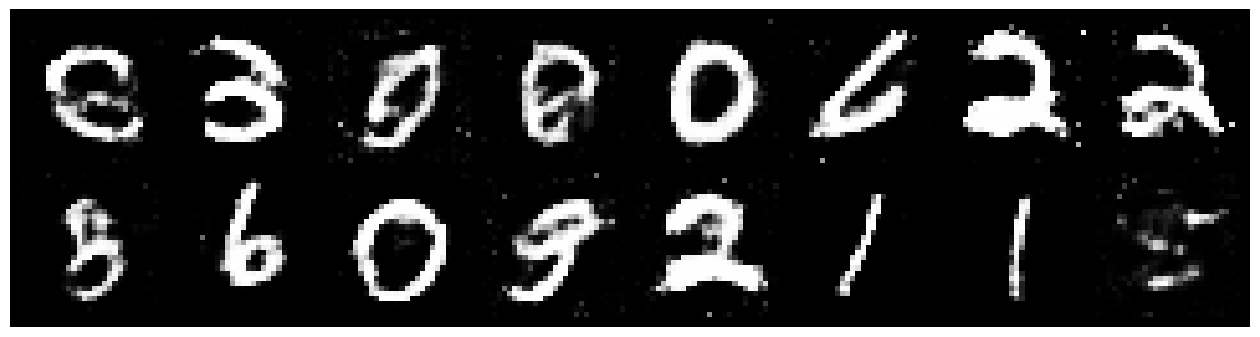

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.3284, Generator Loss: 0.8225
D(x): 0.5281, D(G(z)): 0.4717


In [12]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        
        real_data = images_to_vectors(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        # logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

## DCGAN for CIFAR

Our simple generator for MNIST was fully connected. While that worked
fine for MNIST, it would not work for more complex RGB images.

The DCGAN is a GAN with a generator
designed to do just that, generate larger RGB images using convolutional layers.

Here is the DCGAN architecture:

<img src="img/dcgan.png" title="DCGAN" style="width: 1080px;" />

### Load CIFAR10 data

For our DCGAN experiment, we'll use CIFAR rather than MNIST:

In [13]:
DATA_FOLDER = './torch_data/DCGAN/CIFAR'

def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./torch_data/DCGAN/CIFAR/dataset/cifar-10-python.tar.gz to ./torch_data/DCGAN/CIFAR/dataset


### Networks

Here's another simpler picture of the DCGAN model structures:

<img src="img/dcgan2.png" title="DCGAN" style="width: 640px;" />

Here are PyTorch Modules for them:

In [14]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

The generator is using transpose convolutions with batch normalization:

In [15]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)


Let's create a generator and discriminator and initialize their weights: 

In [16]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

### Optimizers

Next, we set up the optimizers and loss function.

In [17]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 30

### Training

As before, we'll generate a fixed set of noise samples to see the evolution of the
generator over time then start training:

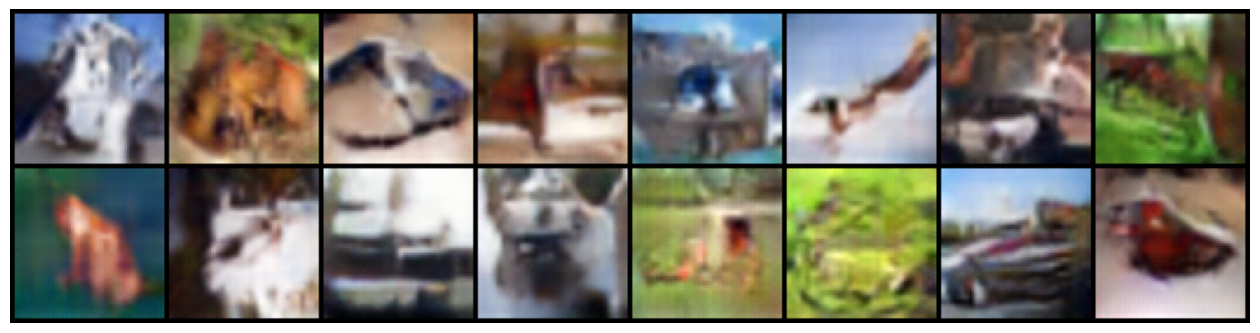

Epoch: [29/30], Batch Num: [400/500]
Discriminator Loss: 1.0003, Generator Loss: 0.7685
D(x): 0.4422, D(G(z)): 0.0792


In [18]:
num_test_samples = 16
test_noise = noise(num_test_samples)

logger = Logger(model_name='DCGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(data_loader):

        # Train Discriminator
        
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Log error and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)


### Exercise

1. Run Vanilla GANs and DC GANs in this lab, show your results
2. Find a 1-class image dataset at least 500 images, try to train in the DC GANs

Have fun with the last exercise!